# CSCE 623 SP 2020 Assignment 4
## LASTNAME, FIRSTNAME
## YYYYMMDD

Solution inspired by submission from Capt Justin Merrick, student, CSCE 623 HW 4, 2019


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import copy


from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split


pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# Part A:  Data setup and exploration

## STEP 1:  Load, clean, split, explore, and transform the data to prepare it for machine learning.  

In [2]:
df = pd.read_csv('ISLR_Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'

In [3]:
# display the names of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
d

### Clean the data
1. Separate the prediction (y) from the features (X)
1. League, Division and NewLeague are categories which should be converted to dummy (on-hot) features

In [4]:
y = df.Salary

# create the dummy variables
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()  #confirm existence of dummies and auto-generated names

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables from categorical features
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')


#since each dummy includes only 2 categories, use a single category to encode all info
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)


X.info()  #confirm existence of dummies and auto-generated names


<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-

### Split data into test and non-test sets

In [5]:
X_nonTest, X_test, y_nonTest, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Explore the data & make prediction about features

## 1.0  Data exploration
Note that exploration can be done on the non-scaled data

In [6]:
X_nonTest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176 entries, Gary Matthews to Harold Reynolds
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        176 non-null    float64
 1   Hits         176 non-null    float64
 2   HmRun        176 non-null    float64
 3   Runs         176 non-null    float64
 4   RBI          176 non-null    float64
 5   Walks        176 non-null    float64
 6   Years        176 non-null    float64
 7   CAtBat       176 non-null    float64
 8   CHits        176 non-null    float64
 9   CHmRun       176 non-null    float64
 10  CRuns        176 non-null    float64
 11  CRBI         176 non-null    float64
 12  CWalks       176 non-null    float64
 13  PutOuts      176 non-null    float64
 14  Assists      176 non-null    float64
 15  Errors       176 non-null    float64
 16  League_N     176 non-null    uint8  
 17  Division_W   176 non-null    uint8  
 18  NewLeague_N  176 non-null    ui

In [7]:
X_nonTest.describe()

            AtBat        Hits       HmRun        Runs         RBI       Walks  \
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000   
mean   399.829545  105.926136   11.721591   53.420455   51.125000   40.664773   
std    140.083544   42.454550    8.829612   24.380424   24.895811   20.288944   
min    127.000000   32.000000    0.000000   14.000000    8.000000    3.000000   
25%    282.750000   72.750000    5.000000   33.000000   31.750000   25.000000   
50%    402.000000  101.000000    9.000000   50.000000   46.500000   36.500000   
75%    512.000000  138.000000   18.000000   70.250000   65.250000   56.000000   
max    687.000000  238.000000   40.000000  130.000000  117.000000   92.000000   

            Years        CAtBat        CHits      CHmRun        CRuns  \
count  176.000000    176.000000   176.000000  176.000000   176.000000   
mean     7.329545   2662.397727   725.897727   71.181818   362.352273   
std      4.878458   2374.975354   678.061397   87.6

In [8]:
X_nonTest.head()

               AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat   CHits  \
Player                                                                         
Gary Matthews  370.0   96.0   21.0  49.0  46.0   60.0   15.0  6986.0  1972.0   
Tim Flannery   368.0  103.0    3.0  48.0  28.0   54.0    8.0  1897.0   493.0   
Vance Law      360.0   81.0    5.0  37.0  44.0   37.0    7.0  2268.0   566.0   
Mike Kingery   209.0   54.0    3.0  25.0  14.0   12.0    1.0   209.0    54.0   
Bill Madlock   379.0  106.0   10.0  38.0  60.0   30.0   14.0  6207.0  1906.0   

               CHmRun   CRuns   CRBI  CWalks  PutOuts  Assists  Errors  \
Player                                                                   
Gary Matthews   231.0  1070.0  955.0   921.0    137.0      5.0     9.0   
Tim Flannery      9.0   207.0  162.0   198.0    209.0    246.0     3.0   
Vance Law        41.0   279.0  257.0   246.0    170.0    284.0     3.0   
Mike Kingery      3.0    25.0   14.0    12.0    102.0      6.0     3.

Confirm that the categorical variable conversion to 1-hot features worked - and explore

In [9]:
X_nonTest.head(5)

               AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat   CHits  \
Player                                                                         
Gary Matthews  370.0   96.0   21.0  49.0  46.0   60.0   15.0  6986.0  1972.0   
Tim Flannery   368.0  103.0    3.0  48.0  28.0   54.0    8.0  1897.0   493.0   
Vance Law      360.0   81.0    5.0  37.0  44.0   37.0    7.0  2268.0   566.0   
Mike Kingery   209.0   54.0    3.0  25.0  14.0   12.0    1.0   209.0    54.0   
Bill Madlock   379.0  106.0   10.0  38.0  60.0   30.0   14.0  6207.0  1906.0   

               CHmRun   CRuns   CRBI  CWalks  PutOuts  Assists  Errors  \
Player                                                                   
Gary Matthews   231.0  1070.0  955.0   921.0    137.0      5.0     9.0   
Tim Flannery      9.0   207.0  162.0   198.0    209.0    246.0     3.0   
Vance Law        41.0   279.0  257.0   246.0    170.0    284.0     3.0   
Mike Kingery      3.0    25.0   14.0    12.0    102.0      6.0     3.

In [10]:
# when exploring relationship between features and predictors, use a combined set
xy_nontest = pd.concat([X_nonTest, y_nonTest], axis=1)

In [11]:
# NOTE - THIS MAKE TAKE A FEW MOMENTS TO CALCULATE & DISPLAY ON YOUR COMPUTER

#switch the below to True to show the pairsplot.
if False:
    sns.pairplot(xy_nontest)
    


In [12]:
#Correlation plot to help features which might be encoding the same information
# magnitude is important: features close to 1 or close to -1 are more correlated with each other

corr = xy_nontest.corr()
corr.style.background_gradient(cmap='coolwarm')

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N,Salary
AtBat,1.000000,0.961582,0.534734,0.892087,0.765184,0.596163,-0.006648,0.183872,0.195501,0.183985,0.208353,0.194470,0.103864,0.355772,0.352920,0.328766,-0.140221,-0.024549,-0.071193,0.464437
Hits,0.961582,1.000000,0.521683,0.895200,0.759635,0.548533,0.001856,0.177368,0.198759,0.154416,0.200184,0.185862,0.086728,0.362029,0.311077,0.284780,-0.150260,-0.054929,-0.083966,0.506027
HmRun,0.534734,0.521683,1.000000,0.641364,0.860290,0.480718,0.110525,0.207206,0.204250,0.488991,0.250582,0.351209,0.241292,0.289467,-0.180717,-0.015863,-0.233849,-0.021430,-0.186843,0.417039
Runs,0.892087,0.895200,0.641364,1.000000,0.749801,0.681410,-0.053443,0.124802,0.136117,0.202771,0.183097,0.164192,0.117441,0.302381,0.152097,0.158972,-0.202675,-0.085784,-0.138719,0.458521
RBI,0.765184,0.759635,0.860290,0.749801,1.000000,0.542619,0.115494,0.240164,0.246509,0.405702,0.259424,0.351747,0.203549,0.369305,0.070721,0.177890,-0.200991,-0.053670,-0.142593,0.476693
Walks,0.596163,0.548533,0.480718,0.681410,0.542619,1.000000,0.079061,0.206313,0.199887,0.341560,0.264576,0.273862,0.374391,0.281950,0.082513,0.069060,-0.054671,-0.041220,-0.031912,0.414155
Years,-0.006648,0.001856,0.110525,-0.053443,0.115494,0.079061,1.000000,0.918384,0.902349,0.733944,0.883534,0.873441,0.836479,-0.017270,-0.057256,-0.134406,0.038952,0.025059,0.030448,0.452424
CAtBat,0.183872,0.177368,0.207206,0.124802,0.240164,0.206313,0.918384,1.000000,0.995645,0.803432,0.984361,0.952399,0.904885,0.071432,0.002247,-0.047643,0.036113,0.026062,0.051028,0.561185
CHits,0.195501,0.198759,0.204250,0.136117,0.246509,0.199887,0.902349,0.995645,1.000000,0.778884,0.984499,0.942754,0.888279,0.087223,-0.004792,-0.045548,0.036050,0.022959,0.057817,0.579364
CHmRun,0.183985,0.154416,0.488991,0.202771,0.405702,0.341560,0.733944,0.803432,0.778884,1.000000,0.823675,0.931082,0.848082,0.119669,-0.156893,-0.139245,-0.073575,0.003355,-0.061595,0.547204


### Prediction of Top-6 Features
List the features that you think will be most important for predicting salary

STUDENT ANSWER:  INSERT YOUR HYPOTHESIS HERE 

Based off of the exploration conducted above, the top 6 features that will best predict salary are, in no particular order: Hits, CRBI, League_N, Division_W, Years, and RBI. It is clear from the correlation table above that there is significant multicollinearity between all of the in-season statistics, as well as all the career statistics. Therefore it is likely that only one or two features from those blocks can explain most of the variance that all of them would. Hits and RBI seemed to be less correlated to each other and cover gaps in in-season block as far as their correlation to other features. The same is true for CRBI and Years. Additionally, these features seemed to have the most consistent trend when plotted against Salary. PutOuts, Errors, and Assists seemed to have little relation to Salary, though an argument could be made for PutOuts. League_N and NewLeague_N are correlated, so only League_N and Division_W were chosen to accompany the in-season and career statistics. While there is not a clear correlation between Salary and these last two features from the graphs above, there does seem to be some difference to the range of the data and the clustered nature of the points makes it difficult to visually approximate the mean. However, since most of the variance in in-season stats and career stats can likely be modeled by one or two features and the other features have very little visual correlation to salary, it is worth it to include these categorical variables in the likely best predictors.

END STUDENT ANSWER


### Scale all X data using nonTest data scaler
* Scale the data features since we dont want some features to affect the linear regressions differently just becasue they have different scales
* Fit the scaler to the non-test data then apply those fitted parameters to the test data to preserve the scaling without being influenced by any aspect of the test data

In [13]:
scaler = StandardScaler()
scaler.fit(X_nonTest) # once we fit a scaler to the non-test data it can be used later to scale the test data without looking at the test data
X_nonTestScaled = pd.DataFrame(scaler.transform(X_nonTest), columns=X_nonTest.columns)  #non-test data scaled using non-test data mean and var
X_testScaled = scaler.transform(X_test)   #test data scaled using non-test data mean and var (prevents "learning" about the test set)

print(X_nonTest.columns)

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_N', 'Division_W', 'NewLeague_N'],
      dtype='object')


###  Explore, then Scale the Y data using a an exponential scaler
notice that the original Y values are very non-normal

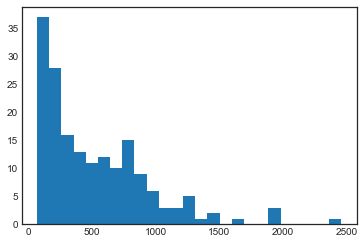

In [14]:
plt.hist(y_nonTest,bins=25);

The response variable, Salary, was noticed to have a non-normal distribution. Using this heavily skewed distribution could negatively affect any model-fitting using a least-squares based regression due to the assumption of normality required on the error term. Therefore, a natural log transform was performed on Salary, yielding a distribution that, while not perfectly normal, is much less heavily skewed and more likely to not violate the normally distributed error assumption. 

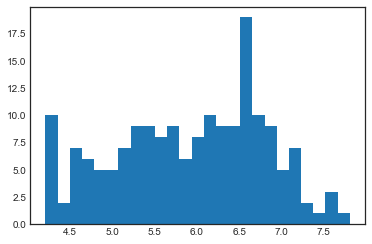

In [15]:
y_nonTestScaled = np.log(y_nonTest)
plt.hist(y_nonTestScaled,bins=25);

Although the new Y values after scaling are not as skewed, they are still not "normally distributed"

Next, build a helper function to compute MSE on predictions in the logspace.  This MSE method will be used by our model while computing the optimization equiation in search for good parameters.
A transform to calculate the $MSE$ in the original dataspace is shown below - and all $MSE$ values are reported in this space.

In [16]:
def transform_mse(y_true, y_pred):
    ydiff = np.exp(y_true) - np.exp(y_pred)
    mse = np.dot(ydiff.T, ydiff)/len(ydiff)
    return mse

dataspace_mse = make_scorer(transform_mse, greater_is_better=False)  #this scorer can be used by the model

# Part B:  Best Subset Selection: Determining the *Best* model features for each size linear regression model

Note:  set the number of features to 3 here to reduce run time during testing.  Setting higher will take significantly longer.
setting runtimes will be longer than picking num_features=3 by approximately:
* 4: 4x longer
* 5: 12x longer
* 6: 28x longer

In [17]:
num_features = 3   #  Only increase this beyond 3 if you have time to wait

## STEP 2:  Write Function For Best-Subset

In [18]:
def bestSubset(X_nonTest,y_nonTest, k):
    kfeatures = []  #placeholder
    kMSE = 1e8  #placeholder
    
    ##########################
    # INSERT STUDENT CODE HERE
    
    dataspace_kMSE = []
    combos = itertools.combinations(X_nonTest.columns, k)
    for combo in combos:
        X = X_nonTest.loc[:,combo]
        val_results = cross_validate(LinearRegression(), X, y_nonTest, scoring='neg_mean_squared_error', cv=5, return_estimator=True)
        avg_mse = np.abs(val_results["test_score"].mean())
        if avg_mse < kMSE:
            kfeatures = combo
            kMSE = avg_mse
            kestimators = val_results["estimator"]
            kX = X
    for estimator in kestimators:
        ypred = estimator.predict(kX)
        dataspace_kMSE.append(transform_mse(y_nonTest, ypred))

    kMSE = np.mean(dataspace_kMSE)
    
    # END STUDENT CODE
    ##########################
    
    return kfeatures, kMSE 

## STEP 3:  Execute best subset

In [19]:
##########################
# INSERT STUDENT CODE HERE


best_features = []
best_mses = []
for k in range(1, num_features+1):
    best_feature, best_mse = bestSubset(X_nonTestScaled, y_nonTestScaled, k)
    best_features.append(best_feature)
    best_mses.append(best_mse)


pd.set_option('display.notebook_repr_html', True)
pd.set_option('max_colwidth', 60)

columns = ['MSE','Features']
best_subset_df = pd.DataFrame(dict(zip(columns, [best_mses, best_features])), index = range(1, num_features+1))
best_subset_df.index.name = 'k'
display(best_subset_df)    
    
# END STUDENT CODE
##########################

,MSE,Features
k,,
1,463562.873968,"(CRuns,)"
2,131843.284881,"(Hits, Years)"
3,130082.826793,"(Hits, Years, League_N)"


## STEP 4:  Plot of Avg Crossval MSE for 6 best models with annotated best point

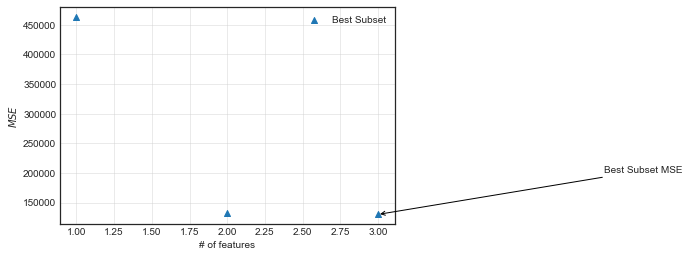

In [20]:
##########################
# INSERT STUDENT CODE HERE

plt.scatter(range(1,num_features+1), best_mses, label='Best Subset', marker='^')
arrowdict = {'arrowstyle':'->'}
plt.annotate('Best Subset MSE', (np.arange(1,num_features+1)[np.argmin(best_mses)], min(best_mses)),
            xytext=(4.5,200000), arrowprops=arrowdict)
plt.xlabel('# of features')
plt.ylabel(r'$MSE$')
plt.grid(alpha=0.5)
plt.legend()
plt.show();

# END STUDENT CODE
##########################

## STEP 5:  Discussion of best subset models

STUDENT RESPONSE BELOW:

Note that this answer was based on a full run from models with feature counts from 1 to 6. In this HW Solution, the setting of K is lower to prevent long run times.

For the lowest $MSE$, $k=6$. $MSE$ continually improves as the number of features increases, yet the rate of improvement slows after adding a second feature. The best subset method found different features than predicted above, yet the general form of the model is similar. Due to the high correlations between in-season statistics, it was predicted that only one or two features would be used in the best model, while Hits and RBI were hypothesized, best subset found AtBat, Hits, and Walks to be of most use. the use of both Hits and AtBat is surprising as they are very highly correlated (0.96). Walks is not surprising as its correlation with most of the other in-season stats is only moderate. Best subset identified Years as the single career statistic necessary for modeling salary, whereas the prediction was CRBI and Years. Again, the high correlation between career statistics is likely the reason for only Years being selected. As predicted, both League_N and Division_W were included in the best subset model.

END STUDENT REPONSE

## STEP 6:  Write Function For Forward Stepwise Subset Selection

In [21]:
def forwardStepwiseSubset(X_nonTest,y_nonTest, k):
    kfeatures = []  #placeholder
    kMSE = []  #placeholder
    
    ##########################
    # INSERT STUDENT CODE HERE
    
    dataspace_kMSE = []
    while len(kfeatures) < k:
        step_mse = 1e8
        for col in X_nonTest.columns:
            features = copy.deepcopy(kfeatures)
            features.append(col)
            kX = X_nonTest.loc[:,features]
            val_results = cross_validate(LinearRegression(), kX, y_nonTest, scoring='neg_mean_squared_error', cv=5, return_estimator=True)
            avg_mse = np.abs(val_results["test_score"].mean())
            if avg_mse < step_mse:
                step_mse = avg_mse
                step_features = features
                step_X = kX
                step_estimator = val_results["estimator"]
        kfeatures = step_features
        for estimator in step_estimator:
            ypred = estimator.predict(step_X)
            dataspace_kMSE.append(transform_mse(y_nonTest, ypred))

    kMSE = np.mean(dataspace_kMSE)
    
    # END STUDENT CODE
    ##########################
    
    return (kfeatures, kMSE) 

## STEP 7:  Execute Forward subset

In [22]:
##########################
# INSERT STUDENT CODE HERE


fwd_features = []
fwd_mses = []
for k in range(1, num_features+1):
    fwd_feature, fwd_mse = forwardStepwiseSubset(X_nonTestScaled, y_nonTestScaled, k)
    fwd_features.append(fwd_feature)
    fwd_mses.append(fwd_mse)
    

pd.set_option('display.notebook_repr_html', True)
pd.set_option('max_colwidth', 60)

columns = ['MSE','Features']
fwd_subset_df = pd.DataFrame(dict(zip(columns, [fwd_mses, fwd_features])), index = range(1, num_features+1))
fwd_subset_df.index.name = 'k'
display(fwd_subset_df)


# END STUDENT CODE
##########################

,MSE,Features
k,,
1,463562.873968,[CRuns]
2,313165.104823,"[CRuns, Hits]"
3,253670.703226,"[CRuns, Hits, Years]"


## STEP 8:  Updated Plot of Avg Crossval MSE & best points

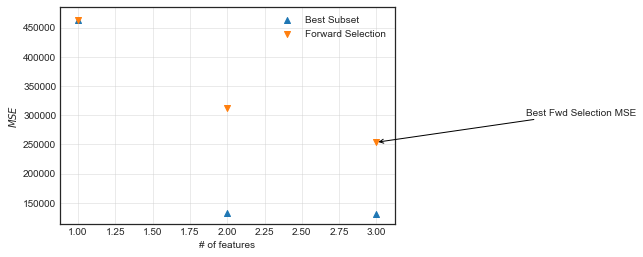

In [23]:
##########################
# INSERT STUDENT CODE HERE

plt.scatter(range(1,num_features+1), best_mses, label='Best Subset', marker='^')
plt.scatter(range(1, num_features+1), fwd_mses, label='Forward Selection', marker='v')
arrowdict = {'arrowstyle':'->'}
plt.annotate('Best Fwd Selection MSE', (np.arange(1,num_features+1)[np.argmin(fwd_mses)], min(fwd_mses)),
            xytext=(4,300000), arrowprops=arrowdict)
plt.xlabel('# of features')
plt.ylabel(r'$MSE$')
plt.grid(alpha=0.5)
plt.legend()
plt.show();

# END STUDENT CODE
##########################

## STEP 9:  Discussion of best foward-stepwise models 

STUDENT RESPONSE BELOW:

Forward stepwise selection yielded a model with worse performance than best subset. The best model occurred at $k=6$. The model produced was similar in form to the hypothesized model, with two in-season features, Hits and AtBats, which are very strongly correlated (0.96); two career feaetures, Years and CRuns, also very strongly correlated (0.88), along with League_N and Division_W which were hypothesized as useful predictors. 

END STUDENT REPONSE

## STEP 10: Discussion and comparison of subset selection methods

STUDENT RESPONSE BELOW:

While the subset selection models were very similar in makeup, the route by which the features were selected was very different. Due to the greedy nature of forward selection, rather than trading in CRuns for Years when $k=2$, the forward selection model keeps CRuns and adds Hits. This greedy selections then leads it to select Hits when $k=3$ as opposed to League_N. By looking at the $MSE$ graph we can see that this greedy method is sub-optimal and is improving at a much slower rate than Best Subset, despite similar initial performance.

END STUDENT REPONSE

## STEP 11: Write a function to execute LASSO

In [24]:
def LASSOSubset(X_nonTest,y_nonTest, k):
    #example of logarithmically spaced alphas for LASSO... may need tweaking
    alphas = np.logspace(-3, 10,num=300)
    kfeatures = [] #placeholder
    kMSE=np.inf  #placeholder
    kalpha = 0  #placeholder

    ##########################
    # INSERT STUDENT CODE HERE

    num_coefs = len(X_nonTest.columns)
    i=0

    
    while num_coefs > k:
        model = Lasso(alpha=alphas[i])
        model.fit(X_nonTest, y_nonTest)
        #determine how many coefficients remain non-zero at this alpha
        #note that the "isClose" operator checks for being arbitrarily close to zeros
        feature_mask = np.logical_not(np.isclose(np.zeros(model.coef_.shape),model.coef_))
        num_coefs = feature_mask.sum()
        i += 1
    val_mse = cross_validate(model, X_nonTest, y_nonTest, scoring=dataspace_mse, cv=5)
    kMSE = np.abs(val_mse["test_score"].mean())
    kfeatures = X_nonTest.columns[feature_mask].values
    kalpha = alphas[i-1]


    # END STUDENT CODE
    ##########################
        
    return (kfeatures, kMSE, kalpha)     

## STEP 12: Execute LASSO

In [25]:
##########################
# INSERT STUDENT CODE HERE


lasso_features = []
lasso_mses = []
lasso_alphas = []
for k in range(1, num_features+1):
    lasso_feature, lasso_mse, lasso_alpha = LASSOSubset(X_nonTestScaled, y_nonTestScaled, k)
    lasso_features.append(lasso_feature)
    lasso_mses.append(lasso_mse)
    lasso_alphas.append(lasso_alpha)
    
    
pd.set_option('display.notebook_repr_html', True)
pd.set_option('max_colwidth', 60)

columns = ['MSE','Features', 'Alpha']
lasso_df = pd.DataFrame(dict(zip(columns, [lasso_mses, lasso_features, lasso_alphas])), index = range(1, num_features+1))
lasso_df.index.name = 'k'
display(lasso_df)
    
# END STUDENT CODE
##########################

,MSE,Features,Alpha
k,,,
1,208767.963406,[CHits],0.548442
2,183912.171126,"[CHits, CRuns]",0.406159
3,156974.613741,"[Hits, CHits, CRuns]",0.272134


## STEP 13: Updated Plot of Avg Crossval MSE & best points

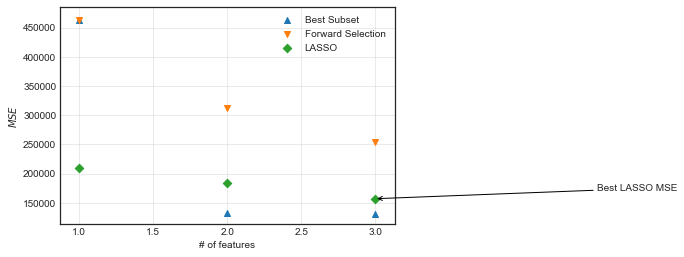

In [26]:
##########################
# INSERT STUDENT CODE HERE

plt.scatter(range(1,num_features+1), best_mses, label='Best Subset', marker='^')
plt.scatter(range(1, num_features+1), fwd_mses, label='Forward Selection', marker='v')
plt.scatter(range(1, num_features+1), lasso_mses, label='LASSO', marker = 'D')
arrowdict = {'arrowstyle':'->'}
plt.annotate('Best LASSO MSE', (np.arange(1,num_features+1)[np.argmin(lasso_mses)], min(lasso_mses)),
            xytext=(4.5,170000), arrowprops=arrowdict)
plt.xlabel('# of features')
plt.ylabel(r'$MSE$')
plt.grid(alpha=0.5)
plt.legend()
plt.show();

# END STUDENT CODE
##########################

## STEP 14: Discussion of best foward-stepwise models 

STUDENT RESPONSE BELOW:

Note that in this HW we are using LASSO to perform feature selection, which is an atypical way of using it.  Usually we would perform a grid search over alpha to obtain the alpha that had the best emprical validation performance, regardless of how many coefficients were non-zero. 

The best Lasso performance occurred at $k=4$. Lasso resulted in performance much closer to Best Subset than Forward Selection. The model favored career features, with Years, CHits, and CRuns augmented by Hits as an in-season predictor. This is different from the Best Subset model at the same k, where Years and Hits were augmented by League_N and Division_W. While this difference makes little difference in $MSE$, it highlights the differences in approach between Best Subset, a feature selection method that bases the feature selection on model performance, and Lasso, a regularization method that results in parameters with value zero due to a penalty on the performance. The model selected by Lasso contains 2 of the hypothesized best predictors, Hits and Years, but does not contain the other hypothesized career predictor, CRBI, though the correlation between CRBI and CHits and CRuns is greater than 0.94. The correlation between CHits and CRuns is >0.98, so there is definitely multicollinearity at play in this model. Additionally, yielding models with exactly k features with non-zero coefficients was an iterative process, requiring a refinement of the alpha grid to include 300 points on the range $[10^{-3}, 10^{10}]$. Fewer number of points yielded some levels of $k$ with identical features or no features.

END STUDENT REPONSE

## STEP 15: Answer Customer Questions

## a

STUDENT RESPONSE BELOW:

For $k=1$, Lasso performed the best, with $\alpha=0.548442$ yielding a model with only CHits having a non-zero coefficient and $MSE=208767$. For $k\in[2,6]$, Best Subset yielded the lowest $MSE$. At $k=2$, $MSE=131843$ was met by a model consisting of Hits and Years. At $k=3$, $MSE=130082$ was met with a model using Hits, Years, and League_N as features. At $k=4$, slightly better performance was achieved, with $MSE=125647$ on a model with Hits, Years, League_N, and Division_W. Lasso also performed very well at $k=4$, with $MSE=141836$ and features of Years, CHits, CRuns, and Hits. This is the closest that another model came to matching the performance of Best Subset after $k=1$. At $k=5$, an $MSE$ of $118430$ was achieved with a model using AtBat, Hits, Walks, Years, and League_N. Finally, at $k=6$, the best achieving model was created with features of AtBat, Hits, Walks, Years, League_N, and Division_W. This combination yielded an $MSE$ of $114948$. 

END STUDENT REPONSE

## b

STUDENT RESPONSE BELOW:

As discussed above, the Best Subset model for $k=6$, consisting of AtBat, Hits, Walks, Years, League_N, and Division_W outperformed all other models.

END STUDENT REPONSE

# END OF ASSIGNMENT